## A intenção do projeto é criar um chatbot baseado em reviews de filmes para que se possa fazer perguntas e manter uma conversa livre

- link do banco de dados https://www.kaggle.com/Cornell-University/movie-dialog-corpus?select=movie_lines.tsv
- referências
>- https://shanebarker.com/blog/deep-learning-chatbot/
> -https://towardsdatascience.com/how-to-create-a-chatbot-with-python-deep-learning-in-less-than-an-hour-56a063bdfc44

In [1]:
!pip3 install gensim
!pip3 install tensorflow
!pip3 install keras

In [1]:
import pandas as pd
import re
import gensim
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from keras.models import Sequential
from scipy.spatial import distance

### Opening movie reviews

In [2]:
messages = pd.read_csv('./chatdata/movie_lines.tsv', header = None, delimiter="\t", quoting=3, encoding='ISO-8859-2')

In [3]:
messages.columns = ['msg_line', 'user_id', 'movie_id', 'user_name', 'msg']

In [4]:
messages.head(10)

,msg_line,user_id,movie_id,user_name,msg
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.
5,L924,u2,m0,CAMERON,Wow
6,L872,u0,m0,BIANCA,Okay -- you're gonna need to learn how to lie.
7,L871,u2,m0,CAMERON,No
8,"""L870",u0,m0,BIANCA,I'm kidding. You know how sometimes you just ...
9,L869,u0,m0,BIANCA,Like my fear of wearing pastels?


### Data exploration

In [5]:
#setting parameters for data visualization
np.set_printoptions(threshold=None, precision=2)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('precision', 2)

#### Data Analysis based on this article
- https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools?utm_source=medium&utm_medium=crosspost&utm_campaign=blog-exploratory-data-analysis-natural-language-processing-tools

In [20]:
!pip3 install \
   pandas matplotlib numpy \
   nltk seaborn sklearn gensim pyldavis \
   wordcloud textblob spacy textstat

     |████████████████████████████████| 283 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 770 kB/s eta 0:00:01
     |████████████████████████████████| 372 kB 760 kB/s eta 0:00:01
     |████████████████████████████████| 102 kB 1.1 MB/s ta 0:00:01
     |████████████████████████████████| 829 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 164 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 272 kB 1.0 MB/s eta 0:00:01     |███████████████████████████████▎| 266 kB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 307 kB/s eta 0:00:01
     |████████████████████████████████| 99 kB 138 kB/s eta 0:00:01     |██████▋                         | 20 kB 1.3 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=eb98d033320aa298d65cbc3d45ca4bf2effbff7824eea19bad49d2897846cdfc
  Stored in directory: /home/douglas/.cache/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da9

In [6]:
data = messages['msg_line']

In [7]:
len(data)

304713

In [8]:
data.describe()

count      304713
unique     304713
top       L485759
freq            1
Name: msg_line, dtype: object

### Number of characters of each message

<AxesSubplot:>

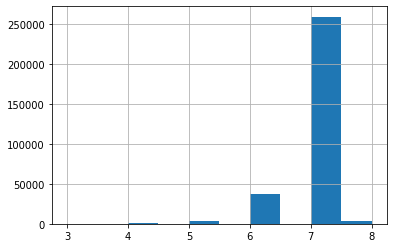

In [9]:
#histogram to display the number of character of each message
data.str.len().hist()

The number of characters are between 0 and 500

### Removing non-alphabetical messages

In [10]:
#there are some non-alphabetical messages that need to be found
data.loc[data.isna()].size

#the above statment does the same of this
#msg.loc[msg.isnull()].size

0

In [537]:
#filling the nan messages with a string
#messages = messages.fillna('.')

### Number of words for each message

<AxesSubplot:>

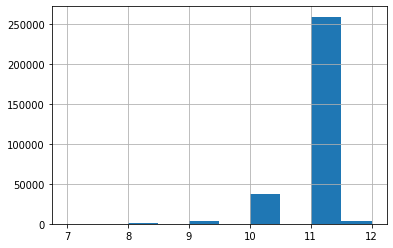

In [11]:
#number of words for each message
data.str.split(' ').\
    map(lambda x: len(str(x))).\
    hist()

The number of words are between 0 and 100

### Average word length

<AxesSubplot:>

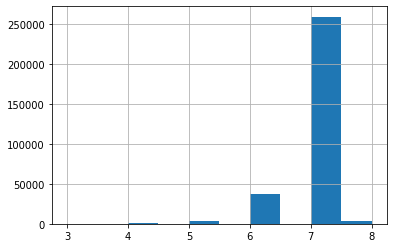

In [12]:
#checking the average word length
data.str.split(' ').\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

The length of words goes from 0 to 15

The word 'I' has the biggest occurrence. There are a lot of messages like dashes that can be removed

## Value types

In [13]:
#checking the average word length
data_set = [type(item) for item in data]
data_set = set(data_set)
data_set

{str}

## Print float values

In [14]:
[it for it in data if isinstance(it, float)]

[]

## Print invalid characters

In [48]:
data_clean = [m.split('L') for m in data]
data_clean = set([ l[0] for l in data_clean])

In [49]:
data_clean

{'', '"'}

There are non-alphanumeric characters